In [1]:
import dask

dask.config.set({"dataframe.query-planning": False})

import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
import _utils

cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error a

In [2]:
condition = 'NSCLC'
panel = '5k'
correction_methods = ['raw','split_fully_purified']
xenium_dir = Path(cfg["xenium_processed_data_dir"])
count_correction_dir = Path(cfg["xenium_count_correction_dir"])
std_seurat_analysis_dir = Path(cfg["xenium_std_seurat_analysis_dir"])
cell_type_annotation_dir = Path(cfg["xenium_cell_type_annotation_dir"])
scrnaseq_processed_data_dir = Path(cfg["scrnaseq_processed_data_dir"])
results_dir = Path(cfg["results_dir"])
palette_dir = Path(cfg["xenium_metadata_dir"])
figures_dir = Path(cfg["figures_dir"])
seurat_to_h5_dir = results_dir / "seurat_to_h5"
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
mixture_k = 50
num_samples = 30


xenium_paths = {}
xenium_annot_paths = {}
xenium_score_mat_paths = {}
for correction_method in correction_methods:
    xenium_paths[correction_method] = {}
    xenium_annot_paths[correction_method] = {}
    xenium_score_mat_paths[correction_method] = {}

    for segmentation in (segmentations := std_seurat_analysis_dir.iterdir()):
        if segmentation.stem != "10x_mm_5um":
            continue
        for condition_dir in (conditions := segmentation.iterdir()):
            if condition_dir.stem != condition:
                continue
            for panel_dir in (panels := condition_dir.iterdir()):
                if panel_dir.stem != panel:
                    continue
                for donor in (donors := panel_dir.iterdir()):
                    for sample in (samples := donor.iterdir()):
                        if sample.stem != '1G73':
                            continue
                        
                        k = (segmentation.stem, condition_dir.stem, panel_dir.stem, donor.stem, sample.stem)
                        name = "/".join(k)

                        # raw samples
                        if "proseg" in segmentation.stem:
                            k_proseg = ("proseg", condition_dir.stem, panel_dir.stem, donor.stem, sample.stem)
                            name_proseg = "/".join(k_proseg)
                            sample_dir = xenium_dir / f"{name_proseg}/raw_results"
                        else:
                            sample_dir = xenium_dir / f"{name}/normalised_results/outs"

                        sample_annotation = (
                            cell_type_annotation_dir
                            / f"{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/output/post_processed_results_df.parquet"
                        )

                        sample_score_mat = (
                            cell_type_annotation_dir
                            / f"{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/output/score_mat.parquet"
                        )

                                
                        if correction_method == "raw":
                            xenium_paths[correction_method][k] = sample_dir
                            xenium_annot_paths[correction_method][k] = sample_annotation
                            xenium_score_mat_paths[correction_method][k] = sample_score_mat


                        # corrected samples
                        else:
                            if correction_method == "split_fully_purified":
                                name_corrected = f"{name}/{normalisation}/reference_based/{reference}/{method}/{level}/single_cell/split_fully_purified/"
                                sample_corrected_counts_path = (
                                    count_correction_dir / f"{name_corrected}/corrected_counts.h5"
                                )

                            else:
                                if correction_method == "resolvi":
                                    name_corrected = f"{name}/{mixture_k=}/{num_samples=}/"
                                elif correction_method == "resolvi_supervised":
                                    name_corrected = f"{name}/{normalisation}/reference_based/{reference}/{method}/{level}/{mixture_k=}/{num_samples=}"
                                elif "ovrlpy" in correction_method:
                                    name_corrected = f"{name}"

                                sample_corrected_counts_path = (
                                    results_dir / f"{correction_method}/{name_corrected}/corrected_counts.h5"
                                )
                            # sample_normalised_counts = (
                            #     std_seurat_analysis_dir / f"{name}/{normalisation}/normalised_counts/{layer}.parquet"
                            # )
                            # sample_idx = (
                            #     std_seurat_analysis_dir / f"{name}/{normalisation}/normalised_counts/cells.parquet"
                            # )

                            xenium_paths[correction_method][k] = sample_corrected_counts_path


ads = readwrite.read_count_correction_samples(xenium_paths, correction_methods[1:])
ads["raw"] = readwrite.read_xenium_samples(xenium_paths["raw"],  transcripts=True, max_workers=6)


for correction_method in correction_methods:

    for k, sd in ads[correction_method].items():
        if sd is not None:
            if correction_method == "raw":
                ad = sd['table']
            else:
                ad = sd

            if correction_method == "raw":
                if k[0] == "proseg_expected":
                    ad.obs_names = ad.obs_names.astype(str)
                    ad.obs_names = "proseg-" + ad.obs_names

                # filter cells and read labels for raw
                df_annot = pd.read_parquet(xenium_annot_paths["raw"][k]).set_index("cell_id")
                ad.uns['df_score_mat'] = pd.read_parquet(xenium_score_mat_paths["raw"][k])
                ad.obs =  ad.obs.join(df_annot)
                ad.obs[level] = ad.obs['first_type']

                ad = ad[ad.obs[level].notna()]
                if level == "Level2.1":
                    # for custom Level2.1, simplify subtypes
                    ad.obs.loc[ad.obs[level].str.contains("malignant"), level] = "malignant cell"
                    ad.obs.loc[ad.obs[level].str.contains("T cell"), level] = "T cell"

                # remove tissue from cell type name
                ad.obs[level] = ad.obs[level].str.replace(r" of .+", "", regex=True)

                if correction_method == "raw":
                    ads["raw"][k]['table'] = ad
                else:
                    ads["raw"][k] = ad
                

            # filter cells and add labels from raw
            if correction_method != "raw":
                ad.obs[level] = ads["raw"][k]['table'].obs[level]
                ad = ad[[c for c in ads["raw"][k]['table'].obs_names if c in ad.obs_names]]
                ads[correction_method][k] = ad


Processing split_fully_purified: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_mm_5um/NSCLC
         /5k/1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                              



/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1792275/543182830.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs[level] = ad.obs[level].str.replace(r" of .+", "", regex=True)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [3]:
sample = list(ads['raw'])[0]

ad_split = ads['split_fully_purified'][sample]

sd = ads['raw'][sample]
ad = sd['table'][ad_split.obs_names,ad_split.var_names]
transcripts = sd['transcripts'].compute()
transcripts = transcripts.query("qv >= 20 and feature_name in @ad.var_names and cell_id in @ad.obs_names")

X_diff = ad.X.copy()
X_diff.data = ad.X.data / ad_split.X.data

In [8]:
ix = (ad.X.data>0) & (ad_split.data==0)

AttributeError: 'AnnData' object has no attribute 'data'

array([0.98470924, 0.65720443, 0.82192354, ..., 1.        , 1.        ,
       1.        ])

/tmp/ipykernel_3642262/100709623.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_doublets['is_marker'] = transcripts_doublets['feature_name'].isin(markers)
/tmp/ipykernel_3642262/100709623.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_doublets[['x_adj', 'y_adj', 'z_adj']]  = transcripts_doublets[['x', 'y', 'z']] - median_coords_aligned
/tmp/ipykernel_3642262/100709623.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

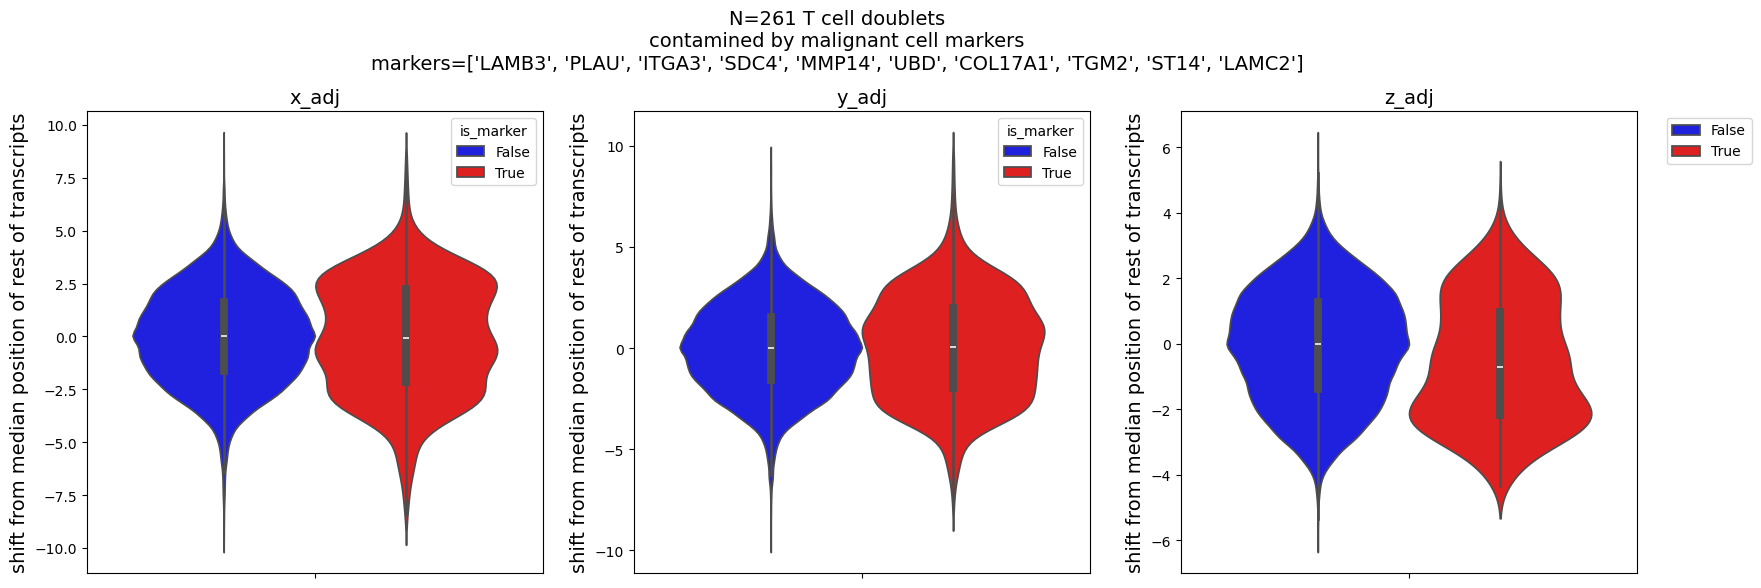

In [ ]:
cti = 'T cell'
# cti = None
ctj = 'malignant cell'
n = 10

if cti is None:
    idx = (
        (ad.obs['second_type'].str.contains(ctj)) & 
        (ad.obs['spot_class'].str.contains('doublet'))
        ).values
else:
    idx = (
        (ad.obs['first_type'].str.contains(cti)) & 
        (ad.obs['second_type'].str.contains(ctj)) & 
        (ad.obs['spot_class'].str.contains('doublet'))
        ).values
doublets = ad[idx].obs_names
transcripts_doublets = transcripts.query("cell_id in @doublets")

top_changed_genes_per_cell_idx = np.argsort(X_diff[idx].toarray(),axis=1)[:,-n:]
top_changed_genes_per_cell = ad.var_names.values[top_changed_genes_per_cell_idx]
top_changed_genes = pd.Series(top_changed_genes_per_cell.flat).value_counts()

markers = top_changed_genes.index.tolist()[:10]
# markers = ['EPCAM']
# markers = [
#     'EPCAM',    # General epithelial/carcinoma marker, often highly expressed.
#     'NKX2-1',   # Key LUAD lineage marker (TTF-1), highly expressed.
#     'TP63',     # Key LUSC lineage marker (p63), highly expressed.
#     'ASCL1',    # Key SCLC/neuroendocrine lineage marker, highly expressed.
#     'SOX2',     # Often amplified/highly expressed in LUSC.
#     'LAMC2',    # Laminin subunit, highly expressed at invasion fronts (epithelial).
#     'DSG3',     # Desmoglein 3, highly expressed LUSC adhesion molecule.
#     'MUC1',     # Mucin 1, often highly expressed in LUAD/glandular epithelium.
#     'SYP',      # Synaptophysin, classic highly expressed SCLC/neuroendocrine marker.
#     'LAMB3'     # Laminin subunit (partners LAMC2), often highly expressed (epithelial).
# ]

transcripts_doublets['is_marker'] = transcripts_doublets['feature_name'].isin(markers)
transcripts_doublets_markers = transcripts_doublets.query('feature_name in @markers')
transcripts_doublets_rest = transcripts_doublets.query('feature_name not in @markers')
transcripts_doublets_median = transcripts_doublets_rest.groupby(["cell_id"])[['x', 'y', 'z']].median()

# add adjusted transcript coordinates by median of all transcripts for each cell
median_coords_aligned = transcripts_doublets_median.loc[transcripts_doublets['cell_id']]
median_coords_aligned.index = transcripts_doublets.index
transcripts_doublets[['x_adj', 'y_adj', 'z_adj']]  = transcripts_doublets[['x', 'y', 'z']] - median_coords_aligned

f, axs = plt.subplots(1,3,figsize=(20, 6))
for i, axis in enumerate(['x_adj','y_adj','z_adj']):
    ax = axs[i]

    sns.boxplot(transcripts_doublets, y=axis, hue="is_marker", palette={False: "blue", True: "red"}, ax=ax)
    # transcripts_doublets_rest[axis].hist(alpha=.5,ax=ax,color='blue',density=True,label="markers")
    # transcripts_doublets_markers[axis].hist(alpha=.5,ax=ax,color='red',density=True,label="rest")

    ax.set_title(f"{axis}",fontsize=14)
    ax.set_ylabel('shift from median position of rest of transcripts',fontsize=14)

plt.suptitle(f"N={len(doublets)} {cti} doublets\ncontamined by {ctj} markers\n{markers=}",y=1.05,fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()